In [79]:
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook
import cv2
from matplotlib import pyplot as plt
import numpy as np
from skimage.feature import local_binary_pattern
from sklearn.decomposition import PCA
import pandas as pd
import ast
import os
from preprocessor import *
from skimage.feature import hog
from feature_extractor import *
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
import math

In [80]:
df = pd.read_csv('datasets/croppedHelen65_2.csv')

In [81]:
df.head()

,images,landmarks
0,2547802012_1.jpg,"[[33, 86], [37, 102], [44, 118], [54, 133], [6..."
1,2547808775_1.jpg,"[[37, 92], [37, 109], [41, 126], [50, 140], [6..."
2,2552816820_2.jpg,"[[35, 69], [36, 86], [40, 104], [48, 120], [59..."
3,2550746669_1.jpg,"[[35, 91], [38, 108], [42, 124], [45, 140], [5..."
4,2548725859_2.jpg,"[[37, 94], [41, 110], [45, 126], [53, 142], [6..."


Show image with landmarks

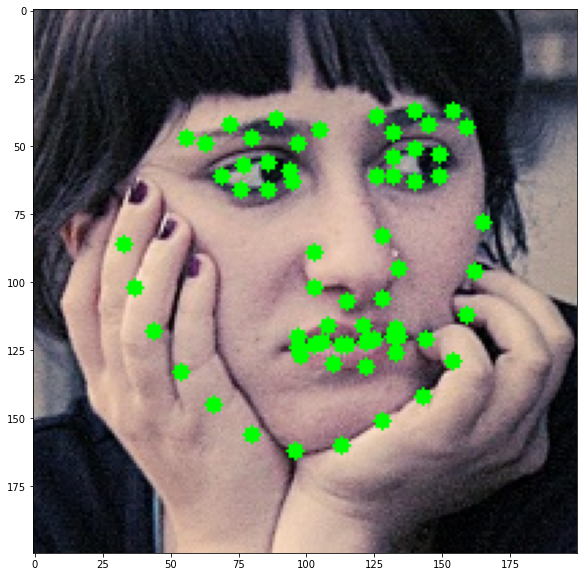

In [82]:
imgname = '2547802012_1.jpg'
landmarks= ast.literal_eval(df.loc[df['images'] == imgname].iloc[0]['landmarks'])
img = cv2.imread('datasets/croppedHelen2/'+imgname)
for i in range(0,len(landmarks)):
  cv2.circle(img, (landmarks[i][0],landmarks[i][1]), 3, (0, 255, 0), -1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#show image with matplotlib and increase figure size
fig = plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()

Training

In [83]:
landmarkslist = df['landmarks'].values.tolist()
landmarks_dataset = np.array([ast.literal_eval(x) for x in landmarkslist])

In [84]:
landmarks_dataset.shape

(2330, 65, 2)

In [85]:
#reshape landmarks to one vector
landmarks_dataset = landmarks_dataset.reshape(landmarks_dataset.shape[0],landmarks_dataset.shape[1]*2)

In [86]:
candidate_shapes = landmarks_dataset

In [87]:
x_bar_initial = candidate_shapes.mean(axis=0)
#Set x_bar to be the same for all images as x_bar_initial, x_bar shape is (imagesSize, x_bar_initial.shape[0])
x_bar = np.tile(x_bar_initial, (candidate_shapes.shape[0],1))

In [98]:
#initial Probability distrubtions, set as uniform, shape is (imagesSize, imagesSize)
probabilities = np.ones((candidate_shapes.shape[0],candidate_shapes.shape[0]))/candidate_shapes.shape[0]

In [88]:
# #Calculate normalized error between predicted shape and ground truth
# def calc_error(predicted_shape, ground_truth):
#     error = 0
#     for i in range(0,len(predicted_shape)):
#         #normalized error is the euclidean distance between the predicted shape and the ground truth divided by the interocular distance
#         error += (np.linalg.norm(predicted_shape[i]-ground_truth[i])) / (np.linalg.norm(ground_truth[lefteye]-ground_truth[righteye])) #TODO
#     error = error/len(predicted_shape)
#     return error

In [89]:
def getSamplesForEachImage(candidate_shapes, probabilities, sampleSize=15):
    rng = np.random.default_rng()
    sampled_shapes =rng.choice(candidate_shapes, sampleSize, replace=False, p=probabilities) #TODO should we sample with replacement?
    return sampled_shapes

In [90]:
def getHogFromLandmarks(landmarks, image, radius=10, multichannel=False, pixels_per_cell=(10, 10), cells_per_block=(2, 2), orientations=8):
    # Define the radius of the region around each landmark to extract LBP features
    radius = 10

    features = []

    if not multichannel:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    for landmark in landmarks:
        # Extract the patch around the landmark
        x, y = landmark
        x= max(10,x) #TODO: REMOVE NEGATIVES FROM DATASET
        y= max(10,y)
        x= min(x, image.shape[1]-1) 
        y= min(y, image.shape[0]-1)
        #Check if the patch is out of bounds
        if (x - radius < 0) or (x + radius >= image.shape[1]) or (y - radius < 0) or (y + radius >= image.shape[0]):
            #Add zero padding
            image = cv2.copyMakeBorder(image, radius, radius, radius, radius, cv2.BORDER_CONSTANT, value=0)
        
        patch = image[y - radius:y + radius, x - radius:x + radius]
        
        fd = hog(patch, orientations=orientations, pixels_per_cell=pixels_per_cell, 
                        cells_per_block=cells_per_block, visualize=False, multichannel=multichannel)
        
        features.extend(fd)

    return np.array(features)

Learning regressors Stage

In [17]:
K = 3 #number of regressors

sampleSize = 15 #5

#regularization parameter
alpha = 0.1

labelslist =[]

#For each image in landmarks_dataset, we sample 15 possible shapes to get a result shape of (landmarks_dataset.shape[0],sampleSize,landmarks_dataset.shape[1])
samples = np.array([getSamplesForEachImage(candidate_shapes, sampleSize=sampleSize, probabilities=probabilities[i]) for i in range(0,landmarks_dataset.shape[0])])

regressors = []
for k in range(K):
    #calculating labels for each sample where the label is the difference between the sample and the ground truth of the corresponing image
    labels = landmarks_dataset[:,np.newaxis,:] - samples
    assert (labels[5,3,:] == (landmarks_dataset[5,:] - samples[5,3,:])).all()
    labels = labels.reshape(labels.shape[0]*labels.shape[1],labels.shape[2])

    #Print labels (offset error) for each image
    #print(labels.sum(axis=1))
    labelslist.append(labels)


    #Now we calculate the feature vector for each sample shape using hog function getHogFromLandmarks
    features = np.array([[getHogFromLandmarks(samples[i,j].reshape(65,2), cv2.imread('datasets/croppedHelen2/'+df.iloc[i]['images'])) for j in range(0,sampleSize)] for i in range(0,landmarks_dataset.shape[0])])
    assert features.shape == (landmarks_dataset.shape[0],sampleSize, 65*2*16) #last number depends on hog parameters

    #reshape labels to (2330*sampleSize,130)
    #reshape features to (2330*sampleSize,2080)
    features = features.reshape(features.shape[0]*features.shape[1],features.shape[2])

    assert features.shape[0] == labels.shape[0]

    #Train regressor with l2 regularization
    reg = Ridge(alpha=alpha).fit(features, labels)
    regressors.append(reg)

    #update samples with the offset calculated from predicted values
    predicted_labels = reg.predict(features)
    predicted_labels = predicted_labels.reshape(landmarks_dataset.shape[0],sampleSize,landmarks_dataset.shape[1])
    samples = samples + predicted_labels
    #round samples to integers
    samples = np.round(samples).astype(int)



Updating Weights

In [65]:
#Create a weight vector of length sampleSize for each image, initially set to e/SampleSize
weights = np.ones((landmarks_dataset.shape[0],sampleSize, 1)) * (1/sampleSize)

In [66]:
weights.shape

(2330, 15, 1)

In [67]:
samples[0].shape

(15, 130)

In [68]:
#Function to calculate affinity matrix A for each image such that A is of size (sampleSize,sampleSize)
def CalcAffinityMatrix(samples, B=0.01): #TODO CHOOSE B, note in gaussian kernel, B is the inverse of the variance, higher B means more sensitive to differences
    AffinityMatrices = np.zeros((samples.shape[0],sampleSize,sampleSize))
    for index,sampleVector in enumerate(samples):
        A = np.zeros((sampleSize,sampleSize))
        for i in range(0,sampleSize):
            for j in range(0,sampleSize):
                A[i,j] = 0 if i==j else np.exp(-B * np.linalg.norm(sampleVector[i]-sampleVector[j]))
        AffinityMatrices[index] = A
    return AffinityMatrices

In [69]:
def UpdateWeights(weights, samples, T=3, B=0.01):
    AffinityMatrices = CalcAffinityMatrix(samples, B=B)
    for t in range(T):
        for index,A in enumerate(AffinityMatrices):
            weights[index] = (np.multiply(weights[index], np.dot(A, weights[index]))) / (np.matmul(weights[index].T, np.dot(A, weights[index])))
    return weights

In [70]:
#Updating weights
updated_weights = UpdateWeights(weights, samples)

In [74]:
updated_weights.shape

(2330, 15, 1)

In [93]:
#Update x_bar using updated weights and regressed samples
x_bar = np.zeros((landmarks_dataset.shape[0],landmarks_dataset.shape[1]))
for index,weight in enumerate(updated_weights):
    x_bar[index] = np.matmul(weight.T, samples[index])

Update probability distribution

In [ ]:
#Updating probability distribution for each image
#It depends on two factors  P(s-xbar) and P(features(xbar)|s-xbar)
#P(s-xbar) is proportional to exp(-1/2 * (s-xbar)^T * covmatrix * (s-xbar))
#covmatrix is learned by ground truth of the image and x_bar of image
#covmatrix is restricted to diagonal by decorrelating the residuals using PCA

for i in range(len(probabilities)):
    #calculate P(s-xbar)
    covmatrix = np.cov((landmarks_dataset[i] - x_bar[i]).T)
    #use PCA to decorrelate the residuals
    pca = PCA(n_components=1)
    pca.fit(covmatrix)
    covmatrix = pca.components_

    #calculate P(s-xbar)
    probabilities[i] = np.exp(-0.5 * np.matmul(np.matmul((landmarks_dataset[i] - x_bar[i]).T, covmatrix), (landmarks_dataset[i] - x_bar[i])))



Testing Errors

In [152]:
# labels = samples - landmarks_dataset[:,np.newaxis,:]
# assert (labels[5,3,:] == (samples[5,3,:] - landmarks_dataset[5,:])).all()
# labels = labels.reshape(labels.shape[0]*labels.shape[1],labels.shape[2])

# #Print labels (offset error) for each image
# print(labels.sum(axis=1))
# labelslist.append(labels)
# labelslist = np.array(labelslist)
# labelslist = abs(labelslist)
# labelslist.sum(axis=(1,2))

[-134   10  -88 ...  -52  203  281]


Testing

In [157]:
sampletest = samples[1,10].reshape(65,2)

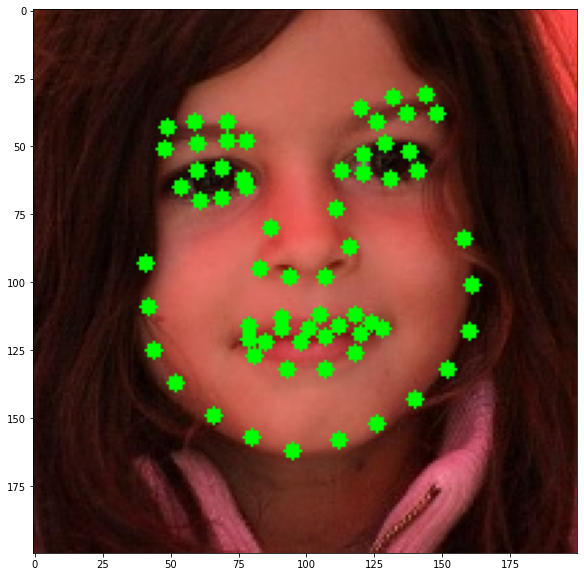

In [158]:
imgname = '2547808775_1.jpg'
landmarks= sampletest
img = cv2.imread('datasets/croppedHelen2/'+imgname)
for i in range(0,len(landmarks)):
  cv2.circle(img, (landmarks[i][0],landmarks[i][1]), 3, (0, 255, 0), -1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#show image with matplotlib and increase figure size
fig = plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()

In [163]:
x_bar.shape

(130,)

(65, 2)
(65, 2)
(65, 2)


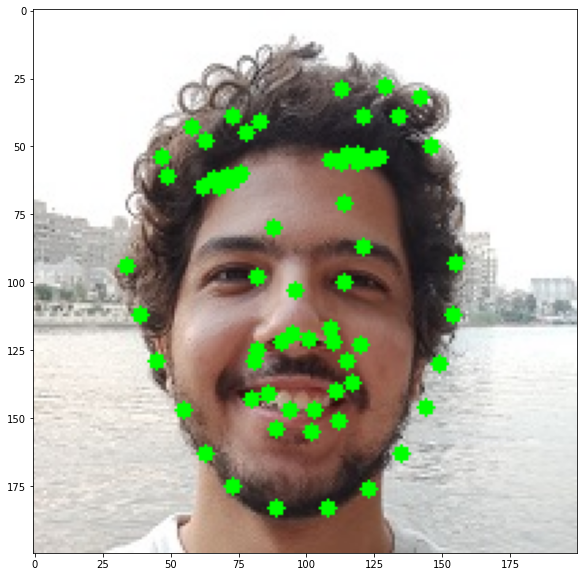

In [171]:
#Read test image
imgname = 'test.jpg'
#set initial shape to mean shape
shape = x_bar.reshape(65,2).round().astype(int)

#Read image
img = cv2.imread(imgname)

#Get hog features from image

#Predict offset from regressors
for k in range(K):
    print(shape.shape)
    hog_features = getHogFromLandmarks(shape, img)
    offset[0] = regressors[k].predict([hog_features])
    shape = shape + offset.reshape((65,2))
    shape = shape.round().astype(int)

landmarks = shape
for i in range(0,len(landmarks)):
  cv2.circle(img, (landmarks[i][0],landmarks[i][1]), 3, (0, 255, 0), -1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#show image with matplotlib and increase figure size
fig = plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()

In [56]:
# sampletest = samples[0,0].reshape(65,2)

In [57]:
# newsample = sampletest + reg.predict(features[0].reshape(1,-1)).reshape(65,2)
# #round newsample to nearest integer
# newsample = np.rint(newsample)

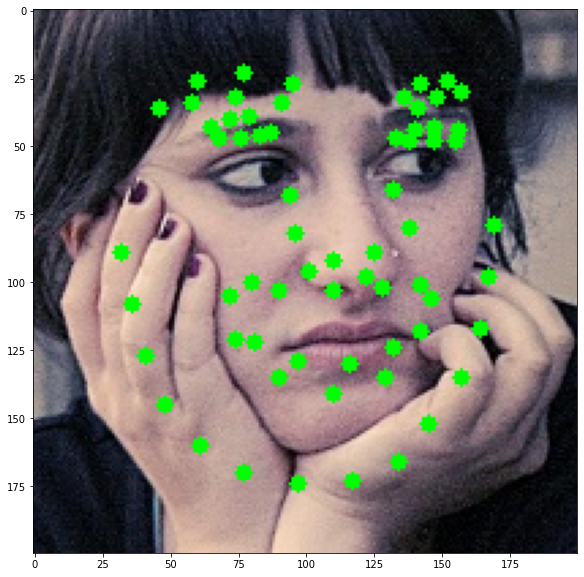

In [58]:
# imgname = '2547802012_1.jpg'
# landmarks= newsample.astype(int)
# img = cv2.imread('datasets/croppedHelen2/'+imgname)
# for i in range(0,len(landmarks)):
#   cv2.circle(img, (landmarks[i][0],landmarks[i][1]), 3, (0, 255, 0), -1)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# #show image with matplotlib and increase figure size
# fig = plt.figure(figsize=(10, 10))
# plt.imshow(img)
# plt.show()

ALIGNMENT TRIAL

In [ ]:
#For each face in the dataset, align its landmarks with respect to the mean shape using Procrustes analysis
aligned_landmarks = np.zeros_like(landmarks_dataset)
transformations = []

for i in range(len(landmarks_dataset)):
    d,z,tfrom = procrustes_analysis(mean_landmark, landmarks_dataset[i])
    aligned_landmarks[i] = z
    transformations.append(tfrom)

(400, 400, 3)


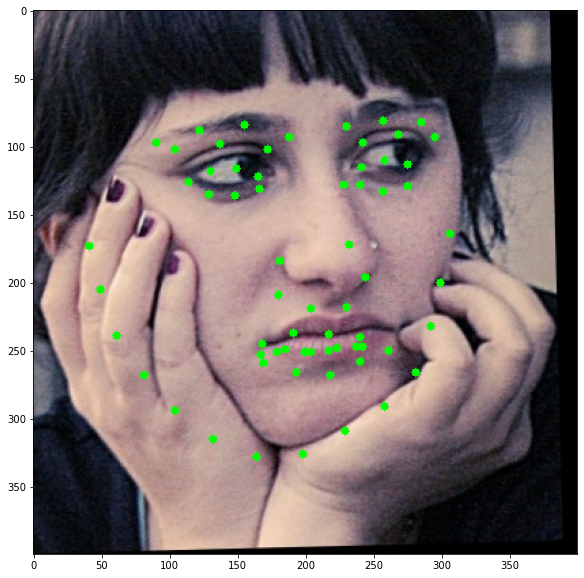

In [10]:
#apply the transformations to the images
# for i in range(len(landmarks_dataset)):
#     imgname = df.iloc[i]['images']
#     img = cv2.imread('datasets/croppedHelen/'+imgname)
#     img = apply_transformation(img, transformations[i])
#     cv2.imwrite('datasets/alignedHelen/'+imgname, img)

def apply_transformation(img, transformation):

    transform_matrix = np.zeros((3,3))
    transform_matrix[:2,:2] = transformation['rotation'] * transformation['scale']
    transform_matrix[:2,2] = transformation['translation']
    transform_matrix[2,2] = 1.0

    # Apply transformation
    rows, cols, _ = img.shape
    # angle_theta = np.degrees(np.arctan2(T[1,0], T[0,0])) #rotation angle
    # M = cv2.getRotationMatrix2D((cols/2,rows/2),angle_theta,b)
    img = cv2.warpAffine(img,transform_matrix[:2],(cols,rows))
    print(img.shape)
    img = cv2.resize(img, (400, 400))

    return img

imgname = df.iloc[0]['images']
img = cv2.imread('datasets/croppedHelen/'+imgname)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = apply_transformation(img, transformations[0])
cv2.imwrite('datasets/alignedHelen/'+imgname, img)


imgname = '2547802012_1.jpg'
landmarks= aligned_landmarks[0]
img = cv2.imread('datasets/alignedHelen/'+imgname)
for i in range(0,len(landmarks)):
  cv2.circle(img, (landmarks[i][0],landmarks[i][1]), 3, (0, 255, 0), -1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#show image with matplotlib and increase figure size
fig = plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()

In [47]:
#RUBBISH CODE FOR TEST
import cv2
import numpy as np
from skimage.feature import local_binary_pattern


In [18]:
img = cv2.imread('datasets/croppedHelen2/'+df['images'][0])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [19]:
from skimage import io
import matplotlib.pyplot as plt

In [20]:
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage import exposure
import matplotlib.pyplot as plt

In [22]:
fd, hog_image, patch = get_hog_features_around_landmark([100,100], gray)

In [23]:
fd.shape

(32,)

In [24]:
fd

array([0.28859516, 0.16095502, 0.23963617, 0.10390485, 0.16142899,
       0.12361706, 0.10386797, 0.2607375 , 0.23168651, 0.08414612,
       0.08372582, 0.11929581, 0.1299868 , 0.02903387, 0.28382145,
       0.28859516, 0.10966147, 0.17941677, 0.14808696, 0.04585638,
       0.21729369, 0.11304966, 0.08149788, 0.03341692, 0.05832834,
       0.05162903, 0.17746494, 0.28859516, 0.28859516, 0.28859516,
       0.11597718, 0.04485294])

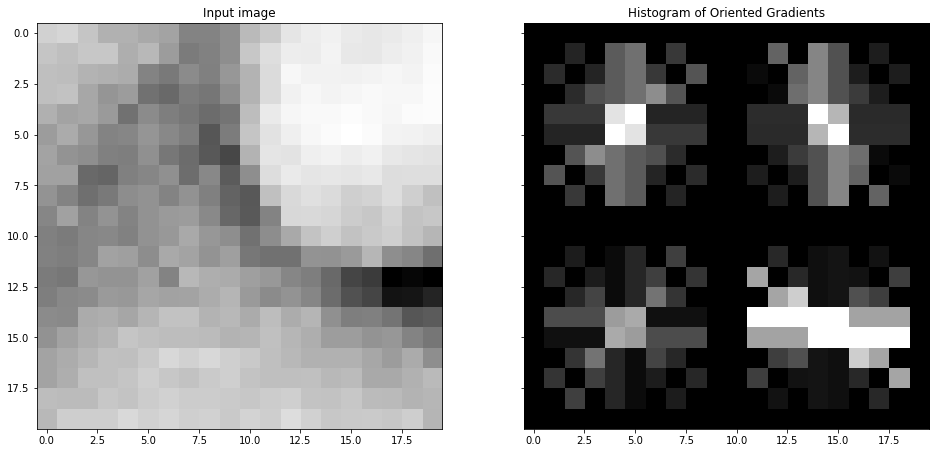

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True) 

ax1.imshow(patch, cmap=plt.cm.gray) 
ax1.set_title('Input image') 

# Rescale histogram for better display 
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10)) 

ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray) 
ax2.set_title('Histogram of Oriented Gradients')

plt.show()

In [72]:
fd.shape

(7056,)